# EDA - Predicting students' dropout

URL: https://archive-beta.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

## Importing modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
from zipfile import ZipFile
from pathlib import Path
import seaborn as sns
import numpy as np
from feature_engine.selection import RecursiveFeatureAddition, DropCorrelatedFeatures
from feature_engine.encoding import CountFrequencyEncoder, RareLabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import LabelEncoder
from feature_engine.creation import MathFeatures
from xgboost import XGBClassifier

## Reading data

In [2]:
def read_data(zip_path: str, target_path='./data/')->pd.DataFrame:
    response = requests.get(zip_path)

    with ZipFile(io.BytesIO(response.content), 'r') as zip_file:
        zip_file.extractall(path=target_path)

    return pd.read_csv(Path(target_path)/'data.csv', sep=';', encoding='utf-8')

In [3]:
PATH = 'https://archive-beta.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip'

student_df = read_data(PATH)

In [59]:
student_df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [12]:
student_df[['GDP',
  'Inflation rate',
  'Tuition fees up to date',
  'Scholarship holder',
  'Curricular units 1st sem (approved)',
  'Curricular units 1st sem (enrolled)',
  'Curricular units 2nd sem (approved)']].head(5)

,GDP,Inflation rate,Tuition fees up to date,Scholarship holder,Curricular units 1st sem (approved),Curricular units 1st sem (enrolled),Curricular units 2nd sem (approved)
0,1.74,1.4,1,0,0,0,0
1,0.79,-0.3,0,0,6,6,6
2,1.74,1.4,0,0,0,6,0
3,-3.12,-0.8,1,0,6,6,5
4,0.79,-0.3,1,0,5,6,6


In [60]:
student_df.shape

(4424, 37)

In [117]:
student_df.Target.value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

## Removing Enrolled students

In [4]:
student_df = student_df.query('Target!="Enrolled"').reset_index(drop=True)

In [5]:
student_df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,1,1,6,9773,1,1,125.0,1,1,1,5,4,122.2,0,0,0,1,1,0,19,0,0,6,7,5,13.600000,0,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
3626,1,1,2,9773,1,1,120.0,105,1,1,9,9,119.0,1,0,1,0,0,0,18,1,0,6,6,6,12.000000,0,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
3627,1,1,1,9500,1,1,154.0,1,37,37,9,9,149.5,1,0,0,1,0,1,30,0,0,7,8,7,14.912500,0,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
3628,1,1,1,9147,1,1,180.0,1,37,37,7,4,153.8,1,0,0,1,0,1,20,0,0,5,5,5,13.800000,0,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


## EDA

In [69]:
student_df.describe(include='float')

,Previous qualification (grade),Admission grade,Curricular units 1st sem (grade),Curricular units 2nd sem (grade),Unemployment rate,Inflation rate,GDP
count,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,132.920606,127.293939,10.534860,10.036155,11.630358,1.231598,-0.009256
std,13.238373,14.611295,5.057694,5.481742,2.667652,1.384911,2.259986
min,95.000000,95.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,125.000000,118.000000,11.000000,10.517857,9.400000,0.300000,-1.700000
50%,133.100000,126.500000,12.341429,12.333333,11.100000,1.400000,0.320000
75%,140.000000,135.100000,13.500000,13.500000,13.900000,2.600000,1.790000
max,190.000000,190.000000,18.875000,18.571429,16.200000,3.700000,3.510000


Nan values

In [70]:
student_df.isna().sum().sum()

0

Drop discrete feature whose categories are over 90%

In [5]:
FEATURES_WITH_REPETITIVE_CATEGORIES = [c for c in student_df.select_dtypes('int64').columns if any(student_df[c].value_counts(normalize=True)>.9)]
print(FEATURES_WITH_REPETITIVE_CATEGORIES)

# Dropping features
student_df.drop(FEATURES_WITH_REPETITIVE_CATEGORIES, axis=1, inplace=True)

['Nacionality', 'Educational special needs', 'International', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (without evaluations)']


### Histograms

In [7]:
float_columns = student_df.select_dtypes('float').columns
print(float_columns)
print(len(float_columns))

Index(['Previous qualification (grade)', 'Admission grade',
       'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)',
       'Unemployment rate', 'Inflation rate', 'GDP'],
      dtype='object')
7


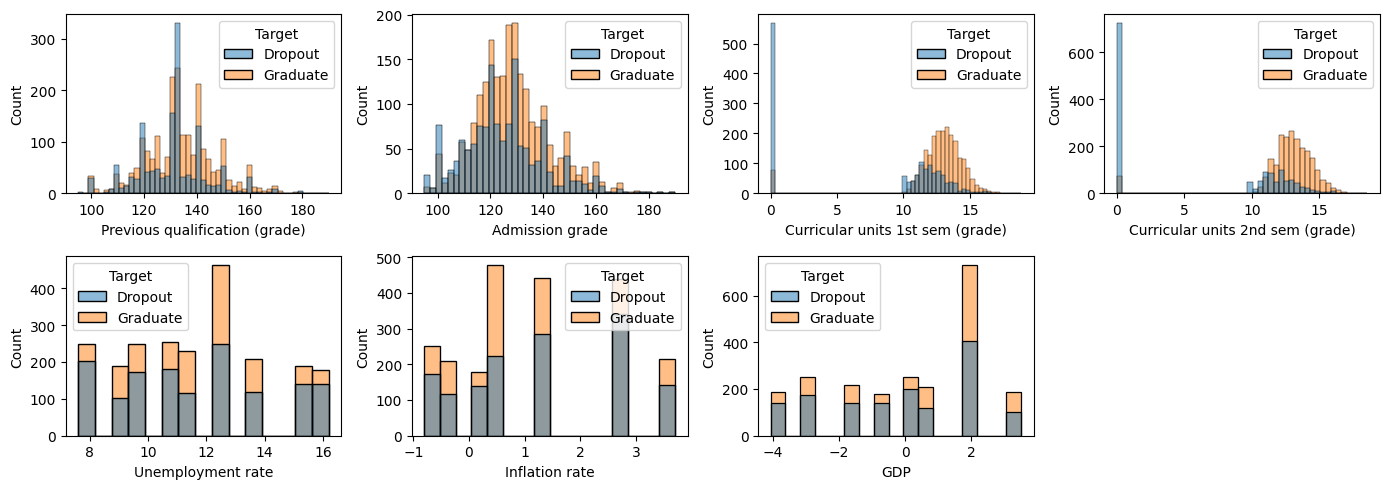

In [92]:
fig, axes = plt.subplots(2, 4, squeeze=True, figsize=(14,5))
axes = axes.flatten()

for i, c in  enumerate(student_df.select_dtypes('float')):
    sns.histplot(ax=axes[i], x=c, hue='Target', data=student_df)

for i in range(len(float_columns), 8):
    fig.delaxes(axes[i])

plt.tight_layout()  # Adjust subplot parameters for a clean layout
plt.show()  # Display the entire subplot grid with all figures

### Correlations

c:\Users\Erick\.virtualenvs\notebooks-UYm4phK3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.draw()
c:\Users\Erick\.virtualenvs\notebooks-UYm4phK3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


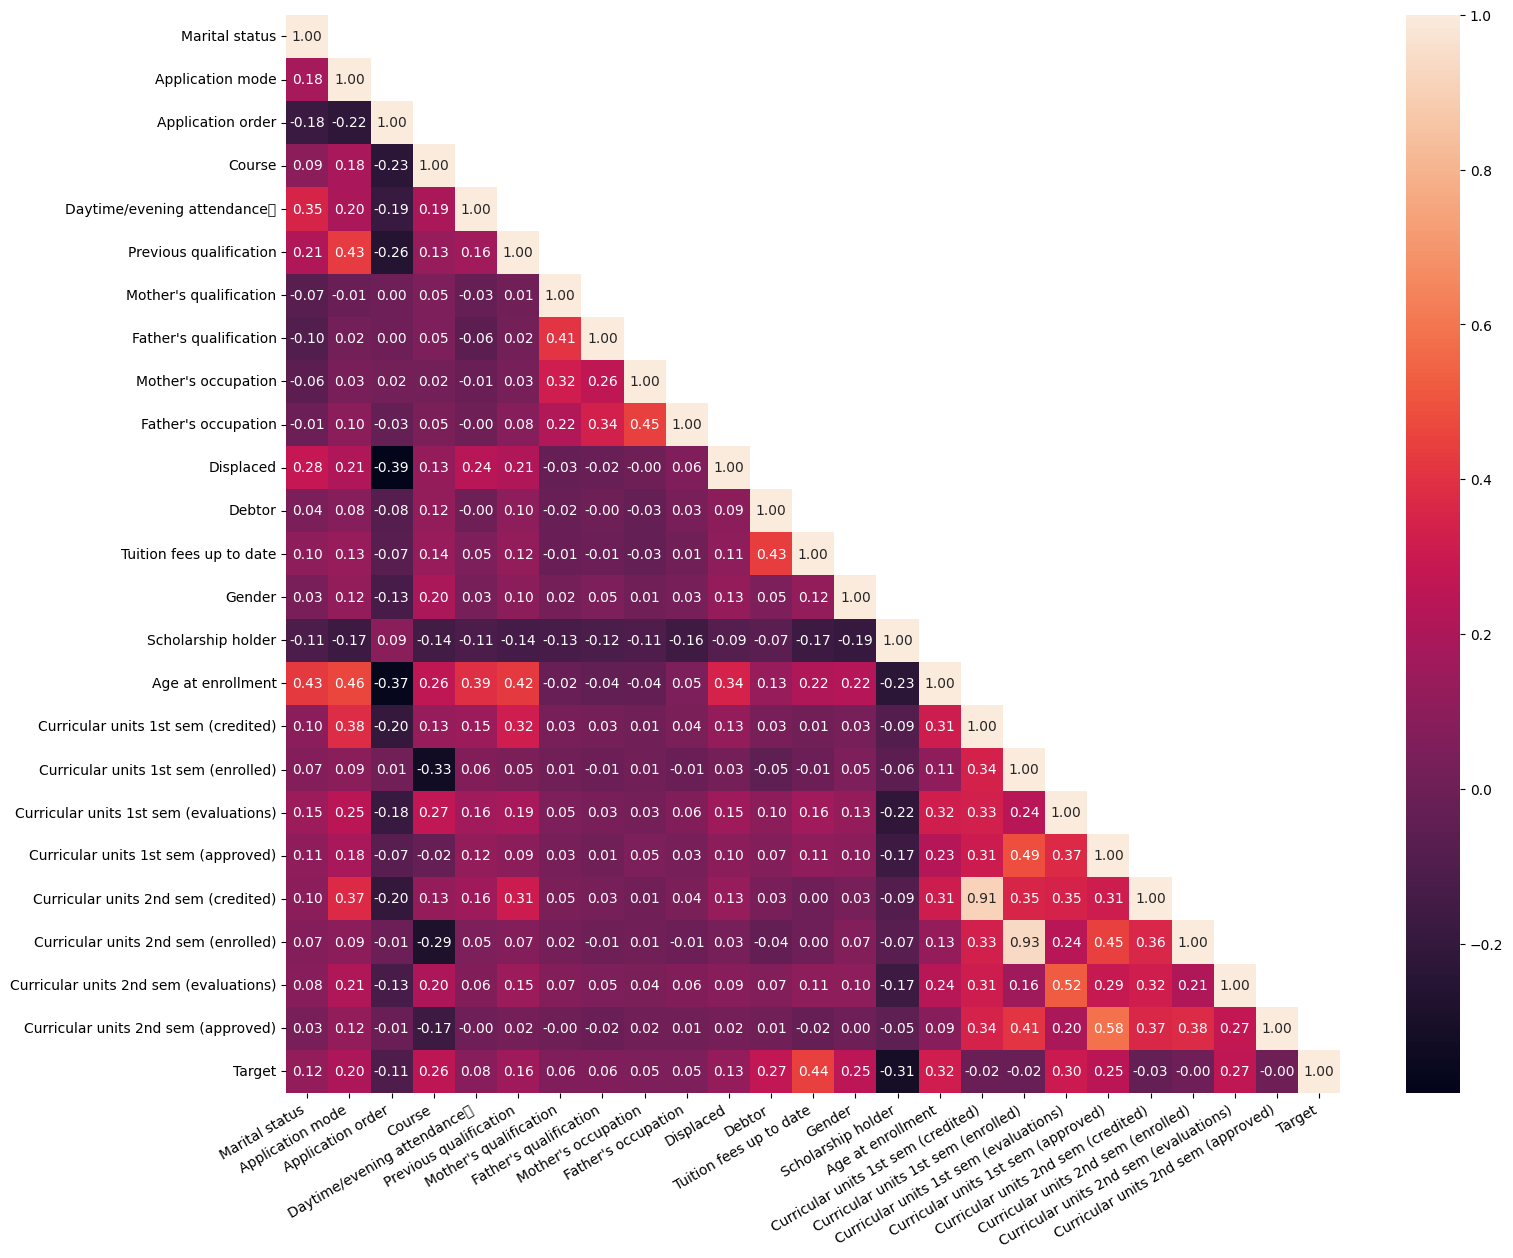

In [8]:
cfe = CountFrequencyEncoder(ignore_format=True, encoding_method='frequency')
data = cfe.fit_transform(student_df[student_df.select_dtypes('int64').columns.tolist()+['Target']])
corr_matrix = data.corr()
mask = np.triu(corr_matrix, k=1)

plt.figure(figsize=(17,14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', mask=mask)
plt.xticks(rotation=30, ha='right')
plt.show()

### Age of enrollment

<Axes: xlabel='Age at enrollment', ylabel='count'>

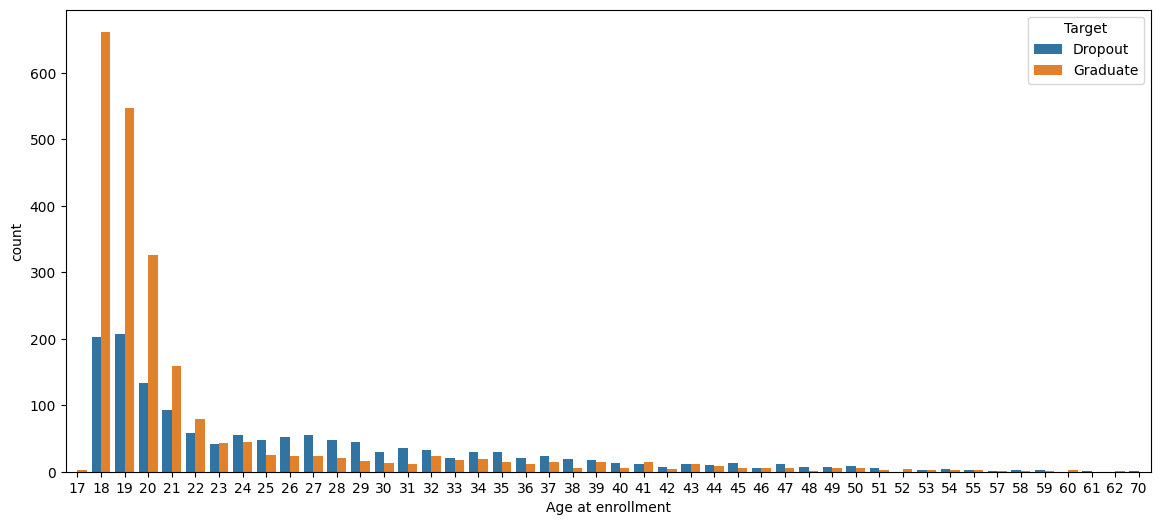

In [95]:
plt.figure(figsize=(14,6))
sns.countplot(x='Age at enrollment', data=student_df, hue='Target')

In [122]:
student_df['Age at enrollment'].between(18,22, inclusive='both').value_counts()

Age at enrollment
True     2466
False    1164
Name: count, dtype: int64

In [123]:
class AgeEnrollmentTransformer(BaseEstimator, TransformerMixin):
    '''
    Transform `Age of enrollment` feature. `True` if is between 18 and 22 including, False otherwise
    '''
    def __init__(self, left:int=18, right:int=22) -> None:
        super().__init__()
        self.left = left
        self.right = right

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None):
        # Perform arbitary transformation
        X['Age at enrollment'] = X['Age at enrollment'].between(self.left, self.right, inclusive='both')*1
        return X

In [128]:
transfomer = AgeEnrollmentTransformer()
is_over_20 = transfomer.fit_transform(student_df)
is_over_20['Target'] = student_df.Target
print(is_over_20['Age at enrollment'].dtype)

int32


<Axes: xlabel='Age at enrollment', ylabel='count'>

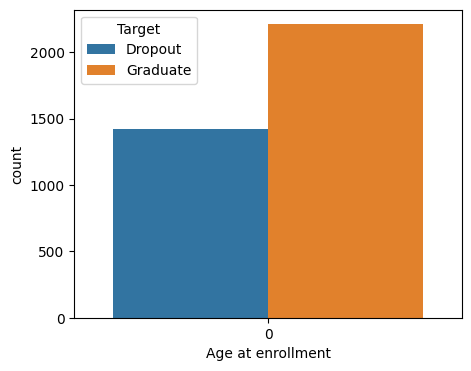

In [132]:
plt.figure(figsize=(5,4))
sns.countplot(x='Age at enrollment', data=is_over_20, hue='Target')

## Features selection

In [12]:
student_df.select_dtypes('float').columns.tolist()

['Previous qualification (grade)',
 'Admission grade',
 'Curricular units 1st sem (grade)',
 'Curricular units 2nd sem (grade)',
 'Unemployment rate',
 'Inflation rate',
 'GDP']

In [6]:
CAT_FEATURES = student_df.select_dtypes(include=['int32', 'int64']).columns.to_list()
CAT_FEATURES

['Marital status',
 'Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance\t',
 'Previous qualification',
 "Mother's qualification",
 "Father's qualification",
 "Mother's occupation",
 "Father's occupation",
 'Displaced',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)']

In [7]:
X = student_df.drop('Target', axis=1)
y = student_df['Target']

### RecursiveFeatureAddition

In [19]:
pipe = Pipeline(steps=[
    ('AgeAtEnrollment', AgeEnrollmentTransformer()),
    ('RareLabelEncoder', RareLabelEncoder(variables=CAT_FEATURES, ignore_format=True, tol=.1)),
    ('Count-Frequency-Encoder', CountFrequencyEncoder(variables=CAT_FEATURES)),
    ('DropCorrelatedFeatures', DropCorrelatedFeatures()),
    ('RecursiveFeatureAddition', RecursiveFeatureAddition(RandomForestClassifier(random_state=42, n_estimators=300, max_depth=10, min_samples_split=4), scoring='f1_weighted', cv=7))
])

pipe.fit(X, y)

c:\Users\Erick\.virtualenvs\notebooks-UYm4phK3\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Marital status is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Erick\.virtualenvs\notebooks-UYm4phK3\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Application order is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Erick\.virtualenvs\notebooks-UYm4phK3\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Daytime/evening attendance	 is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Erick\.virtualenvs\notebooks-UYm4phK3\lib\site-packages\feature_engine\encoding\rare_label.py:216: 

Pipeline(steps=[('AgeAtEnrollment', AgeEnrollmentTransformer()),
                ('RareLabelEncoder',
                 RareLabelEncoder(ignore_format=True, tol=0.1,
                                  variables=['Marital status',
                                             'Application mode',
                                             'Application order', 'Course',
                                             'Daytime/evening attendance\t',
                                             'Previous qualification',
                                             'Nacionality',
                                             "Mother's qualification",
                                             "Father's qualification",
                                             "Mother's occupation",
                                             "Father's occu...
                                                  'Curricular units 2nd sem '
                                                  '(evaluations)',
                                                  'Curricular units 2nd sem '
                                                  '(approved)',
                                                  'Curricular units 2nd sem '
                                                  '(without evaluations)'])),
                ('DropCorrelatedFeatures', DropCorrelatedFeatures()),
                ('RecursiveFeatureAddition',
                 RecursiveFeatureAddition(cv=7,
                                          estimator=RandomForestClassifier(max_depth=10,
                                                                           min_samples_split=4,
                                                                           n_estimators=300,
                                                                           random_state=42),
                                          scoring='f1_weighted'))])

In [20]:
pipe.transform(X_resampled).columns

Index(['Previous qualification (grade)', 'Tuition fees up to date',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (approved)'],
      dtype='object')

### RecursiveFeatureAddition (SMOTE)

In [15]:
y.value_counts()

Target
Graduate    2209
Dropout     1421
Name: count, dtype: int64

In [8]:
smote_tomek = TomekLinks(n_jobs=-1)
student_df_resampled = smote_tomek.fit_resample(X, y)
X_resampled = student_df_resampled[0]
y_resampled = student_df_resampled[1]

print(y_resampled.value_counts())

Target
Graduate    2000
Dropout     1421
Name: count, dtype: int64


In [9]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)
params = {
       'colsample_bylevel':1,
       'learning_rate':0.005,
       'max_depth':35, 
       'min_child_weight':2,
       'n_estimators':300, 
       'n_jobs':-1,
       'eval_metric':'logloss',
       'random_state':42, 
       'objective':'binary:logistic'
    }
pipe = Pipeline(steps=[
    ('RareLabelEncoder', RareLabelEncoder(variables=CAT_FEATURES, ignore_format=True, tol=.05)),
    ('CountFrequencyEncoder', CountFrequencyEncoder(variables=CAT_FEATURES)),
    ('DropCorrelatedFeatures', DropCorrelatedFeatures()),
    ('MathFeatures', MathFeatures(variables=['Inflation rate', 'GDP'], func=['mean'], drop_original=True, new_variables_names=['mean_inflation_gdp'])),
    ('RecursiveFeatureAddition', RecursiveFeatureAddition(XGBClassifier(**params),
                                                                scoring='accuracy',
                                                                cv=10,
                                                                threshold=0.004))
])

pipe.fit(X_resampled, y_encoded)
pipe.transform(X_resampled).columns

c:\Users\Erick\.virtualenvs\experiment-tracking-GDaOvJc5\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Marital status is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Erick\.virtualenvs\experiment-tracking-GDaOvJc5\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Application order is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Erick\.virtualenvs\experiment-tracking-GDaOvJc5\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Daytime/evening attendance	 is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Erick\.virtualenvs\experiment-tracking-GDaOvJc5\lib\site-packages\fea

Index(['Tuition fees up to date', 'Scholarship holder',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (approved)'],
      dtype='object')